![Alt text](image-3.png)

# Laboratorio 2 - Regresión
### Paula Daza Diaz - 202111276
### Juan Camilo Reyes - 201922989
### Sofia Torres Ramírez - 202014872

In [362]:
import numpy as np
import pandas as pd
import csv
import math

import statsmodels.api as sm

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

import ydata_profiling

from sklearn.impute import KNNImputer
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats
%matplotlib inline

In [476]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 1. Entendimiento de los datos

## 1.1 Carga de los datos

Para inciar todo el proceso de regreción es importante tener un archivo de entrenamiento y otro de prueba. En este caso podemos ver las instrucciones para cargar estos dataframes llamados df_laptops y df_laptops_new

In [477]:
df_laptops = pd.read_csv('202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv', sep=',', encoding = 'utf-8', index_col=0)

In [478]:
df_laptops_new = pd.read_csv('202320_Laboratorio 2 - Regresión_data_laptop_data_test_unlabeled.csv', sep=',', encoding = 'utf-8', index_col=0)

## 1.2 Descripción de datos

#### Data frame de entrenamiento

Como primera aproximación, se procede a realizar un análisis exploratorio de los datos. En este caso se quiso conocer el número de filas, columnas y datos que incluye el data frame hallando así los siguientes resultados.
| Número de filas | Número de columnas | Número total de datos |
|--------------|--------------|--------------|
| 1216 | 13 | 15808 |




In [479]:
df_laptops.shape

(1216, 13)

Luego se busca previsualizar los datos para tener un anticipo de los valor que nos podríamos encontrar en cada campo.


In [480]:
df_laptops.sample(5)

Company  TypeName  Ram  Weight      Price  TouchScreen  Ips         Ppi  \
id                                                                            
547  Lenovo  Notebook    4    2.15  10.111883            0    0  141.211998   
88     Asus    Gaming   16    2.20  11.254190            0    1  141.211998   
561  Lenovo  Notebook    4    2.05  10.421281            0    0  141.211998   
992  Lenovo  Notebook    4    1.90   9.576277            0    0  100.454670   
226    Dell  Notebook   16    2.30  10.731342            1    0  141.211998   

                 Cpu_brand     HDD  SSD Gpu_brand       Os  
id                                                          
547          Intel Core i5  1000.0    0     Intel   Others  
88           Intel Core i7  1000.0  128    Nvidia  Windows  
561          Intel Core i3     0.0  128     Intel  Windows  
992  Other Intel Processor     0.0  128     Intel   Others  
226          Intel Core i7  1000.0    0       AMD  Windows

Siguiente a esto se conoce el tipo de valor que contiene cada columna.

In [481]:
df_laptops.dtypes

Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

A continuación se quieren conocer algunas medidas estadísticas descriptivas de los campos numéricos obteniendo así los siguientes resultados

In [482]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1216.000000  1193.000000  1201.000000  1216.000000  1216.000000   
mean      8.458882     2.401572    13.114402     0.145559     0.285362   
std       5.094332     4.844791    28.659102     0.352809     0.451772   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.500000    10.403650     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.320000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1204.000000   1200.000000  1216.000000  
mean    183.830716    441.218800   187.529605  
std     449.708876    927.052855   186.902926  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

#### Data frame de prueba

Como primera aproximación, se procede a realizar un análisis exploratorio de los datos. En este caso se quiso conocer el número de filas, columnas y datos que incluye el data frame hallando asei los siguientes resultados.
| Número de filas | Número de columnas | Número total de datos |
|--------------|--------------|--------------|
| 64 | 13 | 832 |


In [483]:
df_laptops_new.shape

(64, 13)

En este caso podemos ver que DataFrame de prueba es mucho más pequeño que el DataFrame de entrenamiento debido a que un DataFrame de entrenamiento más grande proporciona una base sólida para aprender y generalizar a partir de los datos, lo que puede llevar a un mejor rendimiento en datos nuevos y desconocidos. El DataFrame de prueba, en contraste, se mantiene más pequeño para evaluar imparcialmente la capacidad de generalización del modelo.

In [484]:
df_laptops_new.sample(5)

Company            TypeName  Ram  Weight  TouchScreen  Ips         Ppi  \
id                                                                            
251     Asus              Gaming   16    4.30            0    0  127.335675   
401     Asus              Gaming   16    2.90            0    0  127.335675   
708   Lenovo            Notebook    8    1.80            0    0  157.350512   
1093    Dell           Ultrabook    4    1.40            0    1  165.632118   
23      Dell  2 in 1 Convertible    8    1.62            1    0  165.632118   

          Cpu_brand     HDD  SSD Gpu_brand       Os  CalculatedPrice  
id                                                                    
251   Intel Core i7  1000.0  256    Nvidia  Windows              NaN  
401   Intel Core i7  1000.0  256    Nvidia  Windows              NaN  
708   Intel Core i5     0.0  256     Intel  Windows              NaN  
1093  Intel Core i5     0.0  256       AMD  Windows              NaN  
23    Intel Core i5     0.0  256     Intel  Windows              NaN

Siguiente a esto se conoce el tipo de valor que contiene cada columna.

In [485]:
df_laptops.dtypes

Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

Luego se busca previsualizar los datos para tener un anticipo de los valor que nos podríamos encontrar en cada campo.

In [486]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1216.000000  1193.000000  1201.000000  1216.000000  1216.000000   
mean      8.458882     2.401572    13.114402     0.145559     0.285362   
std       5.094332     4.844791    28.659102     0.352809     0.451772   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.500000    10.403650     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.320000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1204.000000   1200.000000  1216.000000  
mean    183.830716    441.218800   187.529605  
std     449.708876    927.052855   186.902926  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

Luego se crea un perfil en pandas del DataFrame de entrenamiento para poder tener una vista mucho más completa de los datos que se manejarán

In [487]:
!pip install pandas-profiling


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\juanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [488]:
import pandas_profiling

In [489]:
profile = pandas_profiling.ProfileReport(df_laptops)

Como análisis general, se puede ver que hay 66 celdas que no tienen valor y 4 filas duplicadas.

Adicionalmente se puede ver que existen 8 alertas en donde a grandes razgos podeos encontrar que las columnas "weight", "price" y "HDD" tienen valores faltantes. Estos valores se tiene en cuenta más adelante en la seccieon de limpieza de datos.

In [490]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Por último se crea un perfil en pandas del DataFrame de prueba para poder tener una vista mucho más completa de los datos que se manejarán

In [491]:
profile_new = pandas_profiling.ProfileReport(df_laptops_new)

Como análisis general, se puede ver que hay 65 celdas que no tienen valor y no hay filas duplicadas.

Adicionalmente se puede ver que existen 8 alertas en donde a grandes razgos podeos encontrar que las columnas "weight" y "CalculatedPrice" tienen valores faltantes. Estos valores se tiene en cuenta más adelante en la seccieon de limpieza de datos.

In [492]:
profile_new

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Preparación de datos

Para poder trabajar sobre el DataFrame es necesario realizar una limpieza de datos completa. 

## 2.1 Limplieza de datos

Este proceso de limpieza se dividirá en 4 pasos: Completitud, Duplicidad, Consistencia y estadarización.

#### 2.1.1 Eliminación de datos - completitud

Paa poder realizar este paso primero es necesario saber si hay filas con valores vacíos en donde se puede apreciar que para múltiples variables con un procentaje de valores vacíos que podría ser significativo.

In [493]:
(df_laptops.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

Weight         0.018914
HDD            0.013158
Price          0.012336
Ppi            0.009868
Company        0.000000
TypeName       0.000000
Ram            0.000000
TouchScreen    0.000000
Ips            0.000000
Cpu_brand      0.000000
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

Teniendo en cuenta que las 3 primeras variables ("Weight", "HDD" y "Price") poseen un porcentaje de valores vacíos mayor al 1%, en lugar de eliminar esos registros se cambia su valor por la mediana. 

In [494]:
df_laptops.loc[df_laptops.Weight.isna()]

Company            TypeName  Ram  Weight       Price  TouchScreen  Ips  \
id                                                                            
737     Dell  2 in 1 Convertible    8     NaN  344.780371            1    0   
48      Dell            Notebook    4     NaN   10.435465            0    0   
69      Asus              Gaming   12     NaN   10.830970            0    0   
672   Lenovo  2 in 1 Convertible    8     NaN   10.916751            1    1   
1183    Acer            Notebook    4     NaN         NaN            0    0   
1202    Dell           Ultrabook   16     NaN  274.559205            1    0   
865       HP            Notebook    4     NaN   10.789006            0    0   
774       HP           Ultrabook    4     NaN   11.101648            0    0   
609     Acer            Notebook    4     NaN    9.830633            0    0   
220     Dell            Notebook    8     NaN   10.493749            0    0   
500     Asus             Netbook    4     NaN    9.804507            0    0   
733     Acer            Notebook    4     NaN   10.301710            0    0   
1003      HP            Notebook    4     NaN         NaN            0    0   
1108      HP            Notebook    4     NaN    9.962013            0    0   
483    Chuwi            Notebook    4     NaN    9.492612            0    0   
1127      HP           Ultrabook    8     NaN   11.522535            0    0   
1252  Lenovo            Notebook    8     NaN         NaN            0    1   
1205      HP            Notebook    8     NaN         NaN            0    0   
1007      HP           Ultrabook    8     NaN   11.254190            0    0   
393      MSI              Gaming    8     NaN  342.497973            0    0   
1168      HP            Notebook    2     NaN         NaN            0    0   
97      Dell            Notebook    4     NaN         NaN            0    0   
470       HP  2 in 1 Convertible    8     NaN   11.575963            1    1   

              Ppi              Cpu_brand           HDD  SSD Gpu_brand       Os  
id                                                                              
737    165.632118          Intel Core i5   1000.000000    0     Intel  Windows  
48            NaN          Intel Core i5      0.000000  256       AMD  Windows  
69            NaN          Intel Core i7   1000.000000    0    Nvidia   Others  
672    165.632118          Intel Core i5      0.000000  256     Intel  Windows  
1183          NaN  Other Intel Processor  12675.017162    0     Intel  Windows  
1202   276.053530          Intel Core i7      0.000000  512   Intel%%  Windows  
865           NaN          Intel Core i5    500.000000    0     Intel  Windows  
774    125.367428          Intel Core i5      0.000000  256     Intel  Windows  
609   2997.580634  Other Intel Processor      0.000000    0     Intel  Windows  
220    141.211998          Intel Core i5      0.000000  256       AMD   Others  
500           NaN  Other Intel Processor      0.000000    0     Intel  Windows  
733           NaN          Intel Core i5    500.000000    0     Intel  Windows  
1003   111.935204          Intel Core i5  24127.543112    0     Intel  Windows  
1108   141.211998          AMD Processor   1000.000000    0       AMD  Windows  
483    141.211998  Other Intel Processor      0.000000    0     Intel  Windows  
1127          NaN          Intel Core i5           NaN  256     Intel  Windows  
1252   157.350512          Intel Core i5      0.000000  256     Intel  Windows  
1205  2071.670319          Intel Core i5      0.000000  256     Intel  Windows  
1007  4947.212947          Intel Core i7           NaN  256     Intel  Windows  
393    127.335675          Intel Core i7      0.000000  256    Nvidia  Windows  
1168   111.935204  Other Intel Processor      0.000000    0     Intel  Windows  
97    5141.291969          Intel Core i3           NaN  256       AMD   Others  
470    331.264236          Intel Core i7      0.000000  512     Intel  Windows

Todos los valores de la columna Weight que tuvieran valor de NaN se reemplazaron por la mediana

In [495]:
median_weight = df_laptops['Weight'].median()
df_laptops['Weight'].fillna(median_weight, inplace=True)

In [496]:
df_laptops.loc[df_laptops.Weight.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

In [497]:
median_HDD = df_laptops['HDD'].median()
df_laptops['HDD'].fillna(median_HDD, inplace=True)

In [498]:
df_laptops.loc[df_laptops.HDD.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

In [499]:
median_price = df_laptops['Price'].median()
df_laptops['Price'].fillna(median_price, inplace=True)

In [500]:
df_laptops.loc[df_laptops.Price.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

Teniendo en cuenta que el porcentaje de valores vacios en la columna Ppi es menor al 1% se eliminan estos registros

In [501]:
df_laptops.dropna(subset=['Ppi'], inplace=True)

In [502]:
df_laptops = df_laptops[df_laptops['Ppi'] != 'NaN']

In [503]:
(df_laptops.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
Price          0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

En los datos de prueba también hay valores nulos, por lo que se les aplicará el mismo tratamiento:

In [504]:
(df_laptops_new.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

CalculatedPrice    0.053156
Weight             0.000831
Company            0.000000
TypeName           0.000000
Ram                0.000000
TouchScreen        0.000000
Ips                0.000000
Ppi                0.000000
Cpu_brand          0.000000
HDD                0.000000
SSD                0.000000
Gpu_brand          0.000000
Os                 0.000000
dtype: float64

In [505]:
df_laptops_new.loc[df_laptops_new.CalculatedPrice.isna()]

Company            TypeName  Ram  Weight  TouchScreen  Ips         Ppi  \
id                                                                            
1234      HP            Notebook    4    2.10            0    0  141.211998   
691   Lenovo            Notebook    4    1.70            0    0  157.350512   
894      MSI              Gaming   16    2.43            0    1  254.671349   
766     Asus            Notebook    4    2.80            0    0   90.583402   
739     Acer            Notebook    4    2.40            0    0  100.454670   
...      ...                 ...  ...     ...          ...  ...         ...   
1088      HP            Notebook    4    1.29            0    0  276.053530   
750   Lenovo             Netbook    4    1.40            1    0  135.094211   
581     Dell            Notebook    8    1.90            0    0  100.454670   
348     Asus  2 in 1 Convertible    4    1.50            1    0  135.094211   
251     Asus              Gaming   16    4.30            0    0  127.335675   

                  Cpu_brand     HDD  SSD Gpu_brand       Os  CalculatedPrice  
id                                                                            
1234          Intel Core i3  1000.0    0     Intel  Windows              NaN  
691           Intel Core i5     0.0  256     Intel  Windows              NaN  
894           Intel Core i7  2000.0  512    Nvidia  Windows              NaN  
766   Other Intel Processor  1000.0    0    Nvidia  Windows              NaN  
739           Intel Core i3   500.0    0     Intel  Windows              NaN  
...                     ...     ...  ...       ...      ...              ...  
1088  Other Intel Processor     0.0    0     Intel   Others              NaN  
750   Other Intel Processor     0.0  128     Intel  Windows              NaN  
581           Intel Core i5   500.0    0     Intel  Windows              NaN  
348   Other Intel Processor     0.0    0     Intel  Windows              NaN  
251           Intel Core i7  1000.0  256    Nvidia  Windows              NaN  

[64 rows x 13 columns]

In [506]:
porcentaje_na = (df_laptops_new["CalculatedPrice"].isna().mean()) * 100
print(porcentaje_na)

100.0


In [507]:
df_laptops_new = df_laptops_new.drop("CalculatedPrice", axis=1)

#### 2.1.2 Duplicidad

En este momento se busca encontrar campos con valores duplicados. En este caso los campos que podrían indicar una duplicidad de datos serían los campos que representan índices de cada laptop

In [508]:
duplicates = df_laptops.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  6


Se encontraron 6 duplicados, se porcede a eliminarlos

In [509]:
df_laptops = df_laptops.drop_duplicates()

In [510]:
duplicates = df_laptops.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


Ahora se hace lo mismo con el data frame de prueba

In [511]:
duplicates = df_laptops_new.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


Luego de este análisis ya no se encuentran datos duplicados. Sin embargo, esto puede cambiar a la hora de reemplazar los outliers.

#### 2.1.3 Consistencia

#### 2.1.3.1 Categóricos

Para todas las variables no numericas (aparte del titulo y demás campos que puedan representar un valor único) se busca saber qué tipos de valores podría tomar.

In [512]:
df_laptops['Company'].value_counts()

Lenovo       275
Dell         274
HP           252
Asus         138
Acer          94
MSI           50
Toshiba       45
Apple         21
Samsung        8
Razer          7
Microsoft      6
Mediacom       6
Xiaomi         4
Vero           4
Fujitsu        3
Chuwi          3
LG             3
Google         3
Huawei         2
Name: Company, dtype: int64

In [513]:
df_laptops['TypeName'].value_counts()

Notebook                647
Gaming                  188
Ultrabook               183
2 in 1 Convertible      107
Workstation              28
Netbook                  20
Notebook%%                9
&&Notebook                5
Gaming%%                  4
&&Gaming                  3
&&2 in 1 Convertible      2
2 in 1 Convertible%%      1
&&Ultrabook               1
Name: TypeName, dtype: int64

In [514]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['Notebook%%', '&&Notebook'], 'Notebook')

In [515]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['Gaming%%', '&&Gaming'], 'Gaming')

In [516]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['&&2 in 1 Convertible', '2 in 1 Convertible%%'], '2 in 1 Convertible')

In [517]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['&&Ultrabook'], 'Ultrabook')

In [518]:
df_laptops['TypeName'].value_counts()

Notebook              661
Gaming                195
Ultrabook             184
2 in 1 Convertible    110
Workstation            28
Netbook                20
Name: TypeName, dtype: int64

In [519]:
df_laptops['TouchScreen'].value_counts()

0    1024
1     174
Name: TouchScreen, dtype: int64

In [520]:
df_laptops['Ips'].value_counts()

0    858
1    340
Name: Ips, dtype: int64

In [521]:
df_laptops['Cpu_brand'].value_counts()

Intel Core i7            491
Intel Core i5            395
Intel Core i3            127
Other Intel Processor    127
AMD Processor             58
Name: Cpu_brand, dtype: int64

In [522]:
df_laptops['Os'].value_counts()

Windows    1035
Others      142
Mac          21
Name: Os, dtype: int64

Ahora se hace lo mismo pero para el data frame de prueba

In [523]:
df_laptops_new['Company'].value_counts()

Dell        15
HP          13
Lenovo      13
Asus        10
Acer         5
MSI          4
Toshiba      3
Mediacom     1
Name: Company, dtype: int64

In [524]:
df_laptops_new['TypeName'].value_counts()

Notebook              38
Gaming                 9
Ultrabook              8
2 in 1 Convertible     6
Netbook                2
&&Notebook             1
Name: TypeName, dtype: int64

In [525]:
df_laptops_new['TypeName'] = df_laptops['TypeName'].replace(['&&Notebook'], 'Notebook')

In [526]:
df_laptops_new['TypeName'].value_counts()

2 in 1 Convertible    1
Name: TypeName, dtype: int64

In [527]:
df_laptops_new['Cpu_brand'].value_counts()

Intel Core i5            22
Intel Core i7            22
Other Intel Processor    11
Intel Core i3             7
AMD Processor             2
Name: Cpu_brand, dtype: int64

In [528]:
df_laptops_new['Gpu_brand'].value_counts()

Intel     36
Nvidia    20
AMD        8
Name: Gpu_brand, dtype: int64

In [529]:
df_laptops_new['Os'].value_counts()

Windows    56
Others      8
Name: Os, dtype: int64

#### 2.1.3.2 Numéricos

Para todas variables numéricas se busca que sus valores no esten tan alejados el uno del otro

In [530]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1198.000000  1198.000000  1198.000000  1198.000000  1198.000000   
mean      8.469115     2.326267    13.120333     0.145242     0.283806   
std       5.096591     4.465103    28.694639     0.352492     0.451032   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.510000    10.410635     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.310000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1198.000000   1198.000000  1198.000000  
mean    183.789473    428.036347   188.524207  
std     450.807481    857.622970   186.927152  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

In [531]:
def replace_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calcula el porcentaje de valores por debajo de Q1
    percentage_below_Q1 = (column < Q1).mean() * 100

    # Calcula el porcentaje de valores por encima de Q3
    percentage_above_Q3 = (column > Q3).mean() * 100

    print(f"Porcentaje de valores por debajo del 25%: {percentage_below_Q1:.2f}%")
    print(f"Porcentaje de valores por encima del 75%: {percentage_above_Q3:.2f}%")

    # Si el porcentaje es menor al 4%, reemplaza los valores fuera del rango por la mediana
    if percentage_below_Q1 < 4 or percentage_above_Q3 < 4:
        median_value = column.median()
        column[column < lower_bound] = median_value
        column[column > upper_bound] = median_value

# Aplica la función a las columnas ordering, averageRating y numVotes
replace_outliers(df_laptops['Ram'])
replace_outliers(df_laptops['Weight'])
replace_outliers(df_laptops['Price'])
replace_outliers(df_laptops['Ppi'])
replace_outliers(df_laptops['HDD'])
replace_outliers(df_laptops['SSD'])


Porcentaje de valores por debajo del 25%: 1.17%
Porcentaje de valores por encima del 75%: 19.28%
Porcentaje de valores por debajo del 25%: 25.04%
Porcentaje de valores por encima del 75%: 24.79%
Porcentaje de valores por debajo del 25%: 25.04%
Porcentaje de valores por encima del 75%: 24.37%
Porcentaje de valores por debajo del 25%: 22.29%
Porcentaje de valores por encima del 75%: 21.20%
Porcentaje de valores por debajo del 25%: 0.00%
Porcentaje de valores por encima del 75%: 2.50%
Porcentaje de valores por debajo del 25%: 0.00%
Porcentaje de valores por encima del 75%: 12.27%


C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\957580484.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\957580484.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value
C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\957580484.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[colum

In [532]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1198.000000  1198.000000  1198.000000  1198.000000  1198.000000   
mean      6.819699     2.326267    13.120333     0.145242     0.283806   
std       2.000638     4.465103    28.694639     0.352492     0.451032   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.510000    10.410635     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.310000    11.288115     0.000000     1.000000   
max      12.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi          HDD          SSD  
count  1198.000000  1198.000000  1198.000000  
mean    183.789473   407.896494   178.140234  
std     450.807481   515.786466   160.570996  
min      90.583402     0.000000     0.000000  
25%     127.335675     0.000000     0.000000  
50%     141.211998     0.000000   256.000000  
75%     157.350512  1000.000000   256.000000  
max    7328.468865  2000.000000   512.000000

Ahora se hace lo mismo para el dataframe de prueba

In [533]:
df_laptops_new.describe()

Ram     Weight  TouchScreen        Ips          Ppi          HDD  \
count  64.000000  63.000000    64.000000  64.000000    64.000000    64.000000   
mean    8.500000   2.002857     0.187500   0.234375   270.154082   492.187500   
std     5.380742   0.618170     0.393398   0.426956   923.605882   573.849349   
min     2.000000   0.690000     0.000000   0.000000    90.583402     0.000000   
25%     4.000000   1.550000     0.000000   0.000000   127.335675     0.000000   
50%     8.000000   2.020000     0.000000   0.000000   141.211998     0.000000   
75%     8.000000   2.265000     0.000000   0.000000   165.632118  1000.000000   
max    32.000000   4.300000     1.000000   1.000000  7532.205590  2000.000000   

              SSD  
count    64.00000  
mean    165.62500  
std     183.07666  
min       0.00000  
25%       0.00000  
50%     128.00000  
75%     256.00000  
max    1000.00000

In [534]:
def replace_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calcula el porcentaje de valores por debajo de Q1
    percentage_below_Q1 = (column < Q1).mean() * 100

    # Calcula el porcentaje de valores por encima de Q3
    percentage_above_Q3 = (column > Q3).mean() * 100

    print(f"Porcentaje de valores por debajo del 25%: {percentage_below_Q1:.2f}%")
    print(f"Porcentaje de valores por encima del 75%: {percentage_above_Q3:.2f}%")

    # Si el porcentaje es menor al 4%, reemplaza los valores fuera del rango por la mediana
    if percentage_below_Q1 < 4 or percentage_above_Q3 < 4:
        median_value = column.median()
        column[column < lower_bound] = median_value
        column[column > upper_bound] = median_value

# Aplica la función a las columnas ordering, averageRating y numVotes
replace_outliers(df_laptops_new['Ram'])
replace_outliers(df_laptops_new['Weight'])
replace_outliers(df_laptops_new['Ppi'])
replace_outliers(df_laptops_new['HDD'])
replace_outliers(df_laptops_new['SSD'])

Porcentaje de valores por debajo del 25%: 3.12%
Porcentaje de valores por encima del 75%: 18.75%
Porcentaje de valores por debajo del 25%: 25.00%
Porcentaje de valores por encima del 75%: 25.00%
Porcentaje de valores por debajo del 25%: 18.75%
Porcentaje de valores por encima del 75%: 17.19%
Porcentaje de valores por debajo del 25%: 0.00%
Porcentaje de valores por encima del 75%: 4.69%
Porcentaje de valores por debajo del 25%: 0.00%
Porcentaje de valores por encima del 75%: 7.81%


C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\36584854.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column < lower_bound] = median_value
C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\36584854.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column > upper_bound] = median_value
C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\36584854.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column <

In [535]:
df_laptops_new.describe()

Ram     Weight  TouchScreen        Ips          Ppi          HDD  \
count  64.000000  63.000000    64.000000  64.000000    64.000000    64.000000   
mean    6.625000   2.002857     0.187500   0.234375   270.154082   492.187500   
std     1.980059   0.618170     0.393398   0.426956   923.605882   573.849349   
min     2.000000   0.690000     0.000000   0.000000    90.583402     0.000000   
25%     4.000000   1.550000     0.000000   0.000000   127.335675     0.000000   
50%     8.000000   2.020000     0.000000   0.000000   141.211998     0.000000   
75%     8.000000   2.265000     0.000000   0.000000   165.632118  1000.000000   
max     8.000000   4.300000     1.000000   1.000000  7532.205590  2000.000000   

              SSD  
count   64.000000  
mean   152.000000  
std    149.333333  
min      0.000000  
25%      0.000000  
50%    128.000000  
75%    256.000000  
max    512.000000

#### 2.1.3.3 Estandarización
Se requiere ver la proporción de rangos que toman las variables numéricas

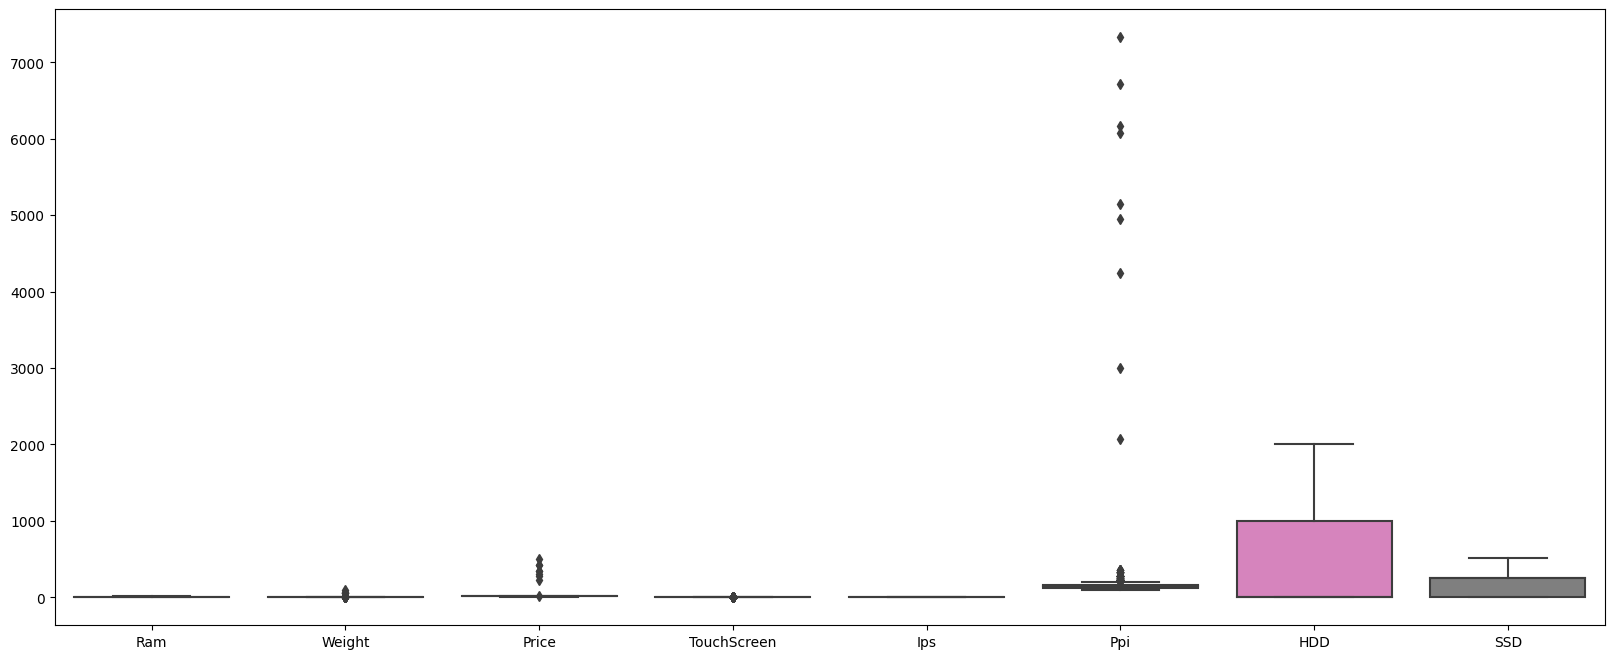

In [536]:
#Visualización de todas las variables numéricas del dataframe original
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops, orient="v")

Se observa que en la columna "Ppi" existen unos valores atípicos muy grandes, por lo que se reemplazan estos valores por la media

In [537]:
# Calcula la media y la desviación estándar de la columna 'Ppi'
mean_hdd = df_laptops['Ppi'].mean()
std_hdd = df_laptops['Ppi'].std()

# Define un umbral para identificar valores atípicos (por ejemplo, 2 desviaciones estándar)
threshold = 2 * std_hdd

# Reemplaza los valores atípicos por la media
df_laptops['Ppi'] = np.where((df_laptops['Ppi'] < (mean_hdd - threshold)) |
                                 (df_laptops['Ppi'] > (mean_hdd + threshold)),
                                 mean_hdd, df_laptops['Ppi'])

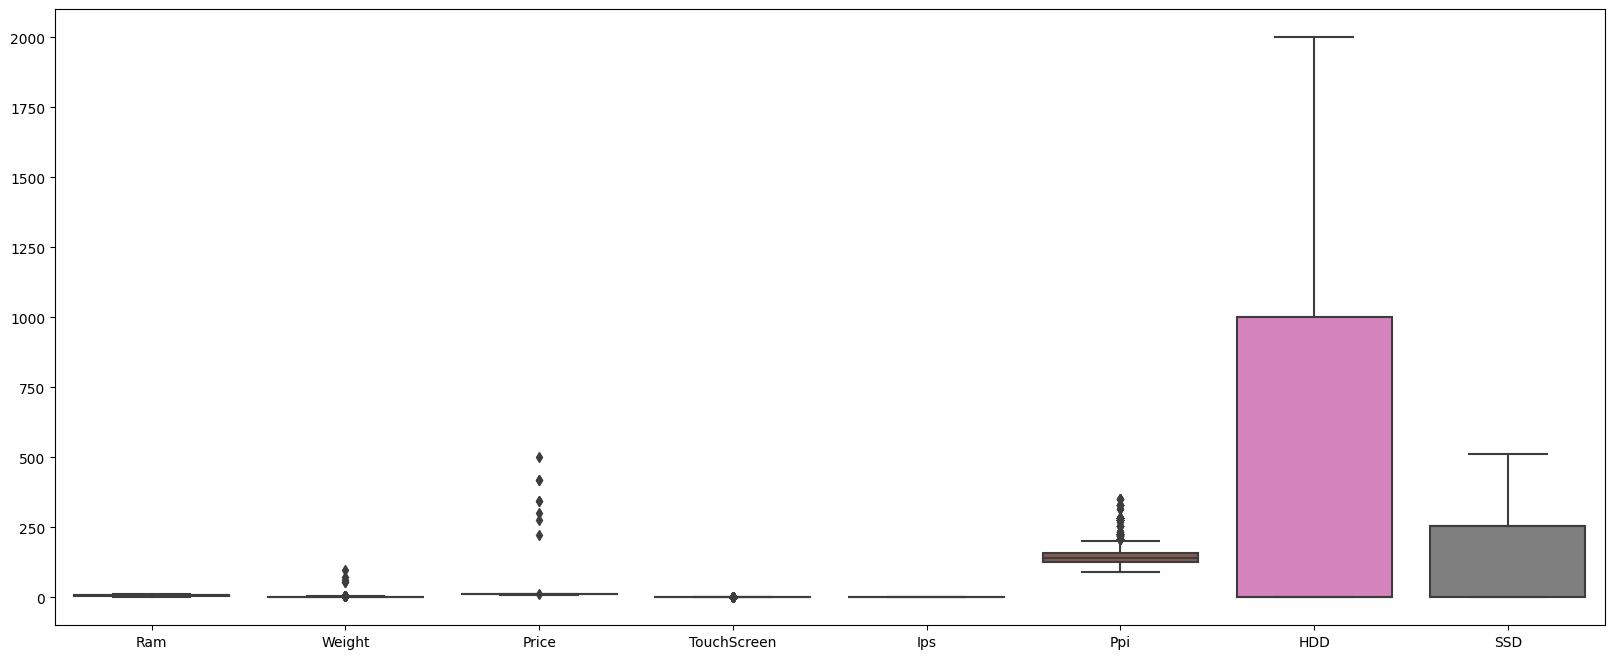

In [538]:
#Visualización de todas las variables numéricas del dataframe original con los outliers reemplazados
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops, orient="v")

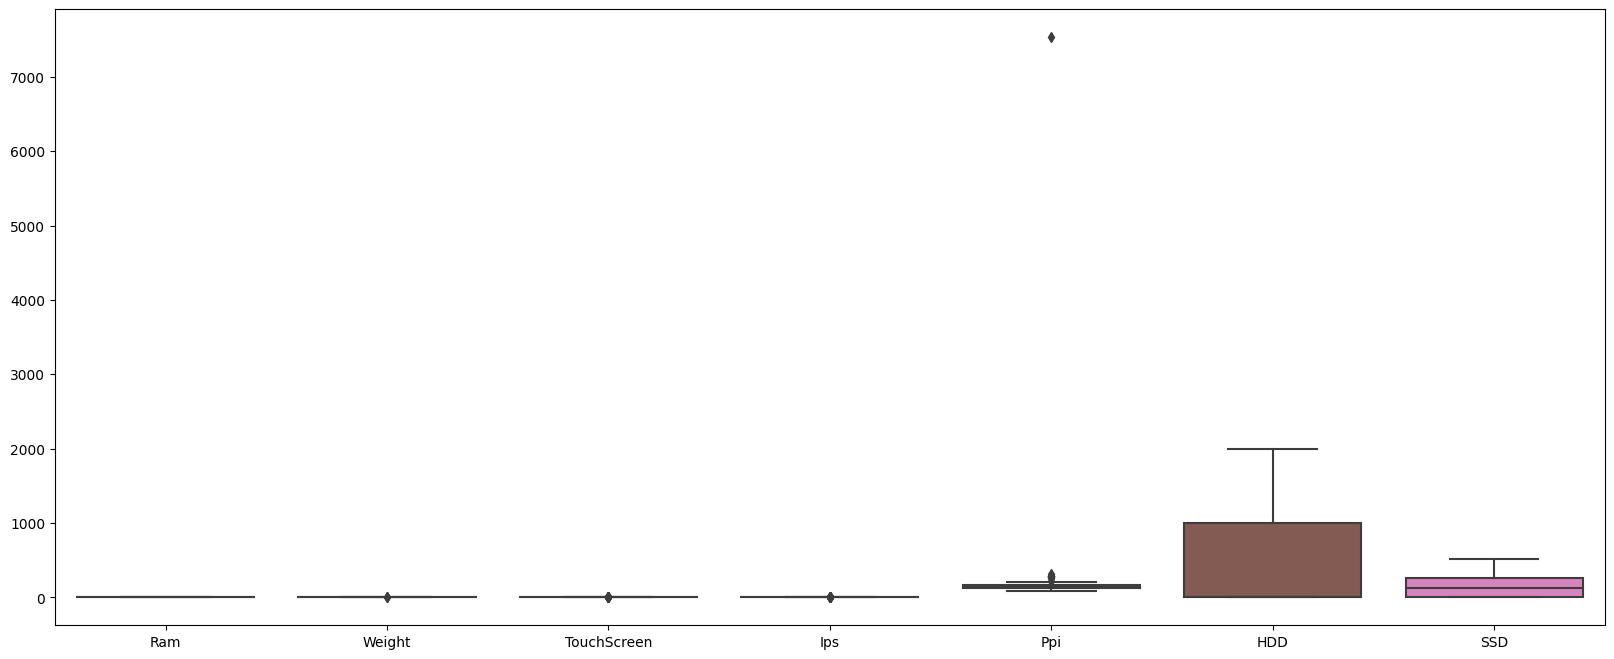

In [539]:
#Visualización de todas las variables numéricas del dataframe de prueba
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops_new, orient="v")

In [540]:
# Calcula la media y la desviación estándar de la columna 'Ppi'
mean_hdd = df_laptops_new['Ppi'].mean()
std_hdd = df_laptops_new['Ppi'].std()

# Define un umbral para identificar valores atípicos (por ejemplo, 2 desviaciones estándar)
threshold = 2 * std_hdd

# Reemplaza los valores atípicos por la media
df_laptops_new['Ppi'] = np.where((df_laptops_new['Ppi'] < (mean_hdd - threshold)) |
                                 (df_laptops_new['Ppi'] > (mean_hdd + threshold)),
                                 mean_hdd, df_laptops_new['Ppi'])

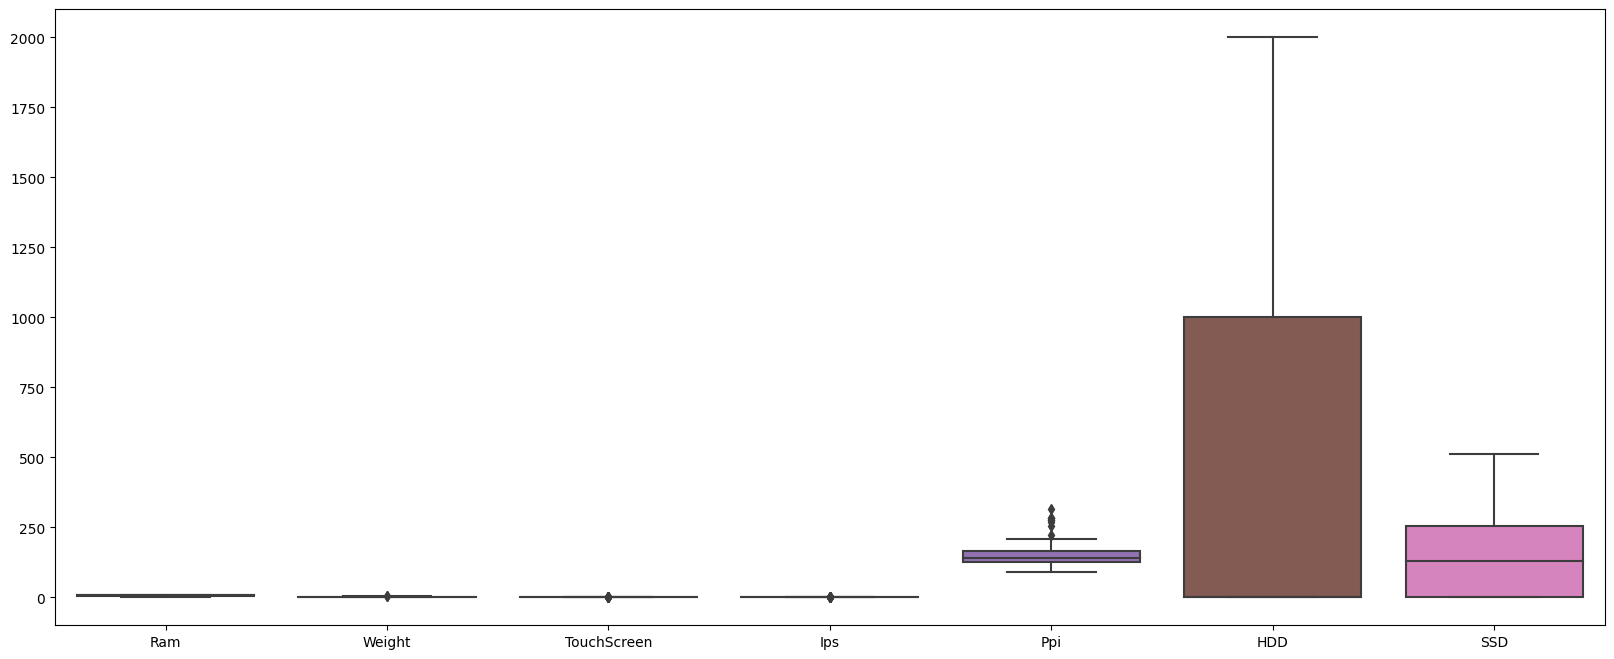

In [541]:
#Visualización de todas las variables numéricas del dataframe de prueba con los outliers reemplazados
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops_new, orient="v")

Dado que "HDD" y "SSD" tienen valores muy grandes en comparación con otras variables,  se aplicará una transformación logarítmica a las variables. Esto reduciría la amplitud de los valores mientras mantiene las relaciones proporcionales entre ellos.

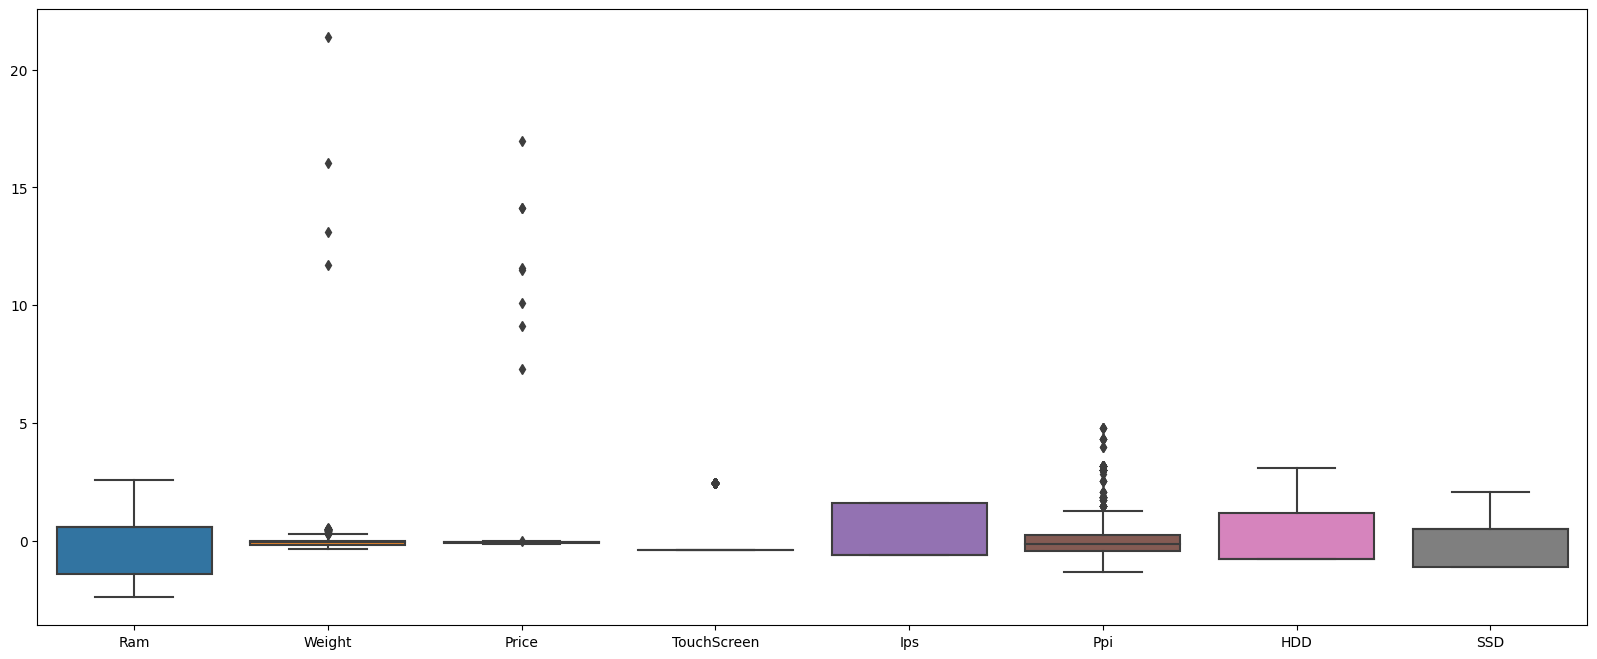

In [542]:
from sklearn.preprocessing import StandardScaler

# Selecciona solo las columnas numéricas
numeric_columns = df_laptops.select_dtypes(include=['int64', 'float64'])

# Inicializa el StandardScaler
scaler = StandardScaler()

# Aplica la estandarización a las columnas numéricas
df_laptops_standardized = pd.DataFrame(scaler.fit_transform(numeric_columns), columns=numeric_columns.columns)

# Combina las columnas estandarizadas con las columnas no numéricas
df_laptops[numeric_columns.columns] = df_laptops_standardized

#Visualización de todas las variables numéricas del dataframe original estandarizados
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops, orient="v")


In [543]:
# Excluimos la columna 'id' si es necesario
df_laptops_new = df_laptops_new.drop(columns=['id'])

# Selecciona solo las columnas numéricas
numeric_columns = df_laptops_new.select_dtypes(include=['int64', 'float64'])

# Inicializa el StandardScaler
scaler = StandardScaler()

# Aplica la estandarización a las columnas numéricas
df_laptops_standardized = pd.DataFrame(scaler.fit_transform(numeric_columns), columns=numeric_columns.columns)

# Combina las columnas estandarizadas con el DataFrame de prueba (incluyendo la columna 'id')
df_laptops_new[numeric_columns.columns] = df_laptops_standardized

fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_laptops_new, orient="v")

KeyError: "['id'] not found in axis"

### 2.2 Identificación de variables a utilizar

### Correlación de variables con Precio

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) 'precio'.

In [ ]:
features = ['Weight','Ram','Ips','Ppi','TouchScreen','HDD','SSD']

calcular la proporción de valores nulos en el daframe

In [ ]:
df_laptops[['Price']+features].isnull().sum() / df_laptops.shape[0]

Price          0.060935
Weight         0.060935
Ram            0.060935
Ips            0.060935
Ppi            0.060935
TouchScreen    0.060935
HDD            0.060935
SSD            0.060935
dtype: float64

In [ ]:
df_laptops = df_laptops.dropna(subset=["Price"]+features)

In [ ]:
df_laptops.shape

(1125, 13)

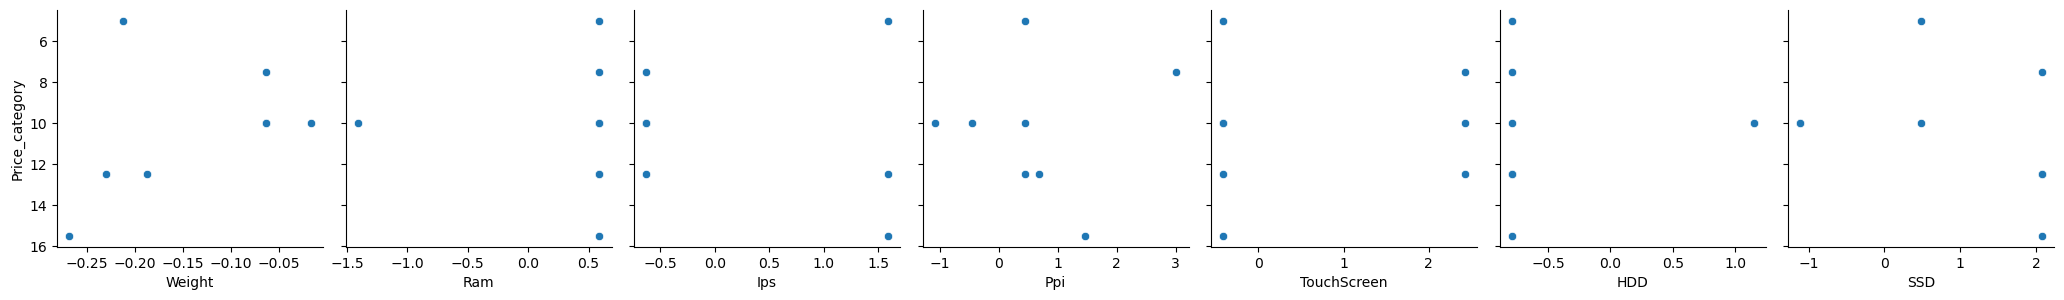

In [ ]:
# Crear el gráfico
sns.pairplot(df_laptops, height=3, y_vars="Price_category", x_vars=features, kind="scatter", diag_kind="bar")

# Mostrar el gráfico
plt.show()


C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\2644111981.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_laptops.corr(), cmap='Blues', vmin=0, vmax=1)


<AxesSubplot: >

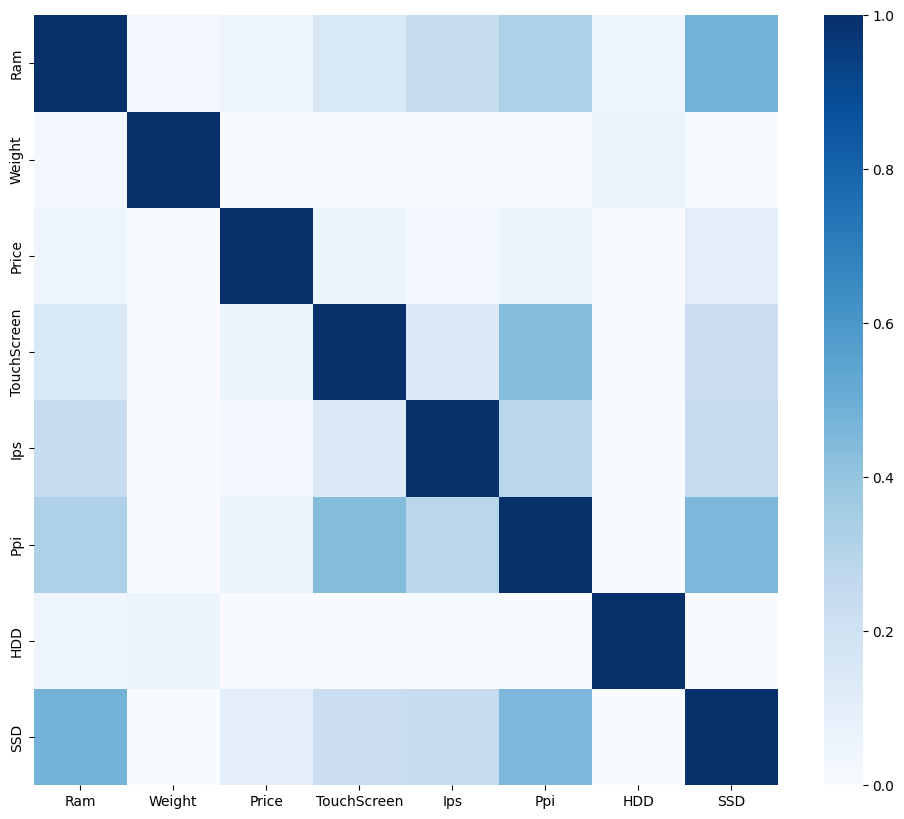

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_laptops.corr(), cmap='Blues', vmin=0, vmax=1)

In [ ]:
df_laptops.corr()

C:\Users\juanc\AppData\Local\Temp\ipykernel_21360\3901513941.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_laptops.corr()


Ram    Weight     Price  TouchScreen       Ips       Ppi  \
Ram          1.000000  0.029766  0.044332     0.152175  0.247931  0.321809   
Weight       0.029766  1.000000 -0.011678    -0.066637 -0.034731 -0.033101   
Price        0.044332 -0.011678  1.000000     0.055549  0.029055  0.061869   
TouchScreen  0.152175 -0.066637  0.055549     1.000000  0.136994  0.438267   
Ips          0.247931 -0.034731  0.029055     0.136994  1.000000  0.291256   
Ppi          0.321809 -0.033101  0.061869     0.438267  0.291256  1.000000   
HDD          0.044202  0.057034 -0.030481    -0.191108 -0.108596 -0.308445   
SSD          0.477667 -0.003024  0.098895     0.225597  0.241581  0.454756   

                  HDD       SSD  
Ram          0.044202  0.477667  
Weight       0.057034 -0.003024  
Price       -0.030481  0.098895  
TouchScreen -0.191108  0.225597  
Ips         -0.108596  0.241581  
Ppi         -0.308445  0.454756  
HDD          1.000000 -0.438062  
SSD         -0.438062  1.000000

# 3. Modelamiento

Se realiza el partimiento de los datos de prueba y entrenamiento, se utiliza un valor de 30/70

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_laptops[features], df_laptops['Price'], test_size=0.3, random_state=1)

In [ ]:
X_train.shape, y_train.shape

((787, 7), (787,))

In [ ]:
X_test.shape, y_test.shape

((338, 7), (338,))

## 3.1 Entrenamiento del primer modelo

Utilizando el modelo de sklearn

In [ ]:
regression = LinearRegression()

In [ ]:
regression.fit(X_train, y_train)

LinearRegression()

### 3.1.1 Interpretacion de los coeficientes del intercepto

Dado que los coeficientes muestran cuales variables tienen un mayor impacto en el modelo, se puede decir que las variables que tienen mayor fuerza en la rediccion en el precio son: HHD y SSD

In [ ]:
pd.DataFrame({'columns': features, 'coef': regression.coef_})

columns      coef
0       Weight -0.007525
1          Ram -0.026997
2          Ips  0.001787
3          Ppi  0.013351
4  TouchScreen  0.069776
5          HDD  0.053189
6          SSD  0.114651

Se utiliza el intercepto para determinar le valor base de la estimacion, en este caso el valor de Price base seria 9.714937644449606

In [ ]:
regression.intercept_

0.016585191505681836

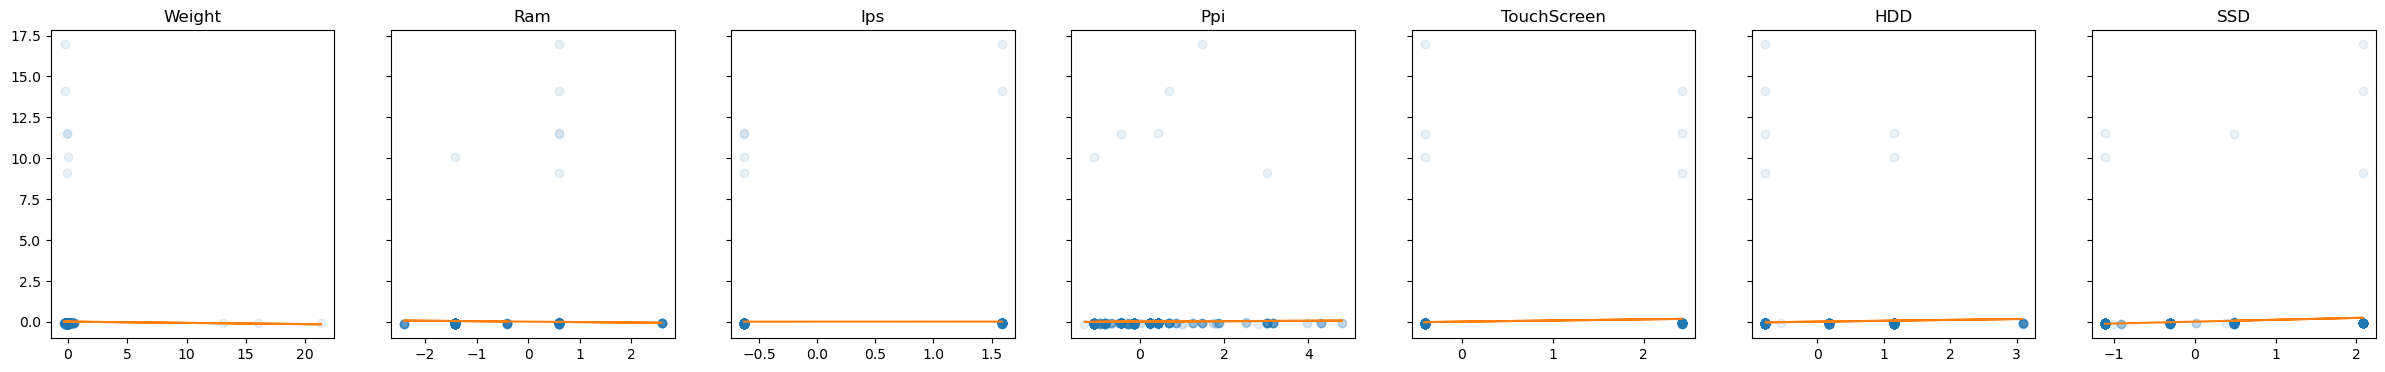

In [ ]:
f, axs = plt.subplots(1, len(features), sharey=True,figsize=(30, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha=0.1)
    axs[i].plot(x, x*m+b)
    axs[i].set_title(col)


### 3.1.2 Validacion del modelo

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [ ]:
print('Train', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test', mean_absolute_error(y_test, regression.predict(X_test)))

Train 0.19641019423437903
Test 0.17181449962400203


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [ ]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 1.0869448084576574
Test: 0.8696640014130236


<b> Analisis del error<b> 

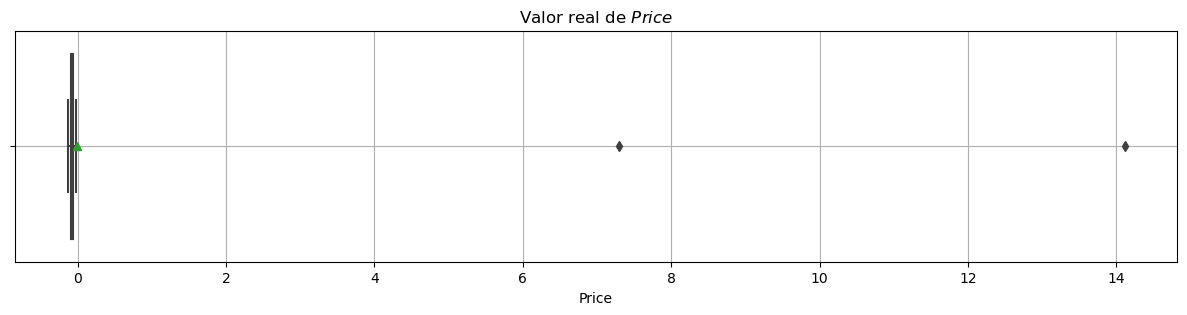

In [ ]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{Price}$')
plt.grid()
plt.show()

In [ ]:
y_test.describe()

count    338.000000
mean      -0.016638
std        0.869049
min       -0.135545
25%       -0.095962
50%       -0.078839
75%       -0.063920
max       14.110936
Name: Price, dtype: float64

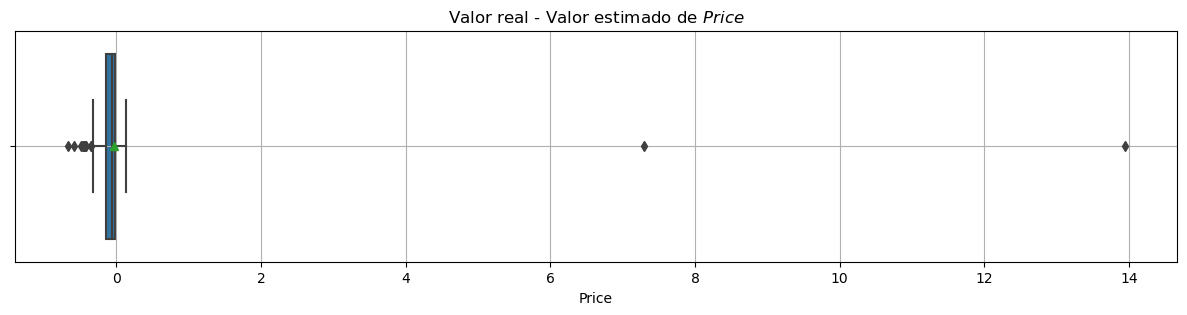

In [ ]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{Price}$')
plt.grid()
plt.show()

## 3.2 Entrenamiento del segundo modelo

In [ ]:
pipeline = Pipeline ([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
pd.DataFrame({'columns': features, 'coef': pipeline['model'].coef_})

columns      coef
0       Weight -0.008070
1          Ram -0.027306
2          Ips  0.001776
3          Ppi  0.013428
4  TouchScreen  0.071189
5          HDD  0.051833
6          SSD  0.114285

In [ ]:
pipeline['model'].intercept_

0.014083492922134323

<b>MAE<b>

In [ ]:
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train)))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test)))


Train: 0.19641019423437903
Test: 0.17181449962400205


<b>RMSE<b>

In [ ]:
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

Train: 1.0869448084576574
Test: 0.8696640014130237


## 3.3 Validación de supuestos de la regresión lineal

### 3.3.1 Colinealidad

Se observa una baja colinealidad entre columnas

<AxesSubplot: >

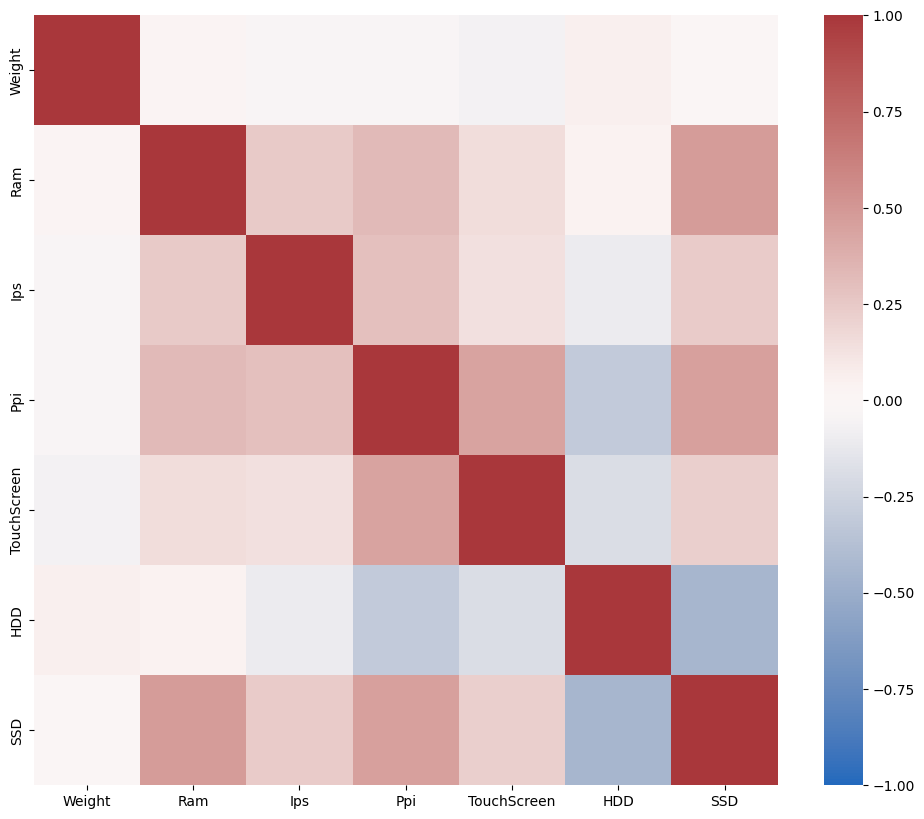

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

In [ ]:
df_laptops[features].corr()

Weight       Ram       Ips       Ppi  TouchScreen       HDD  \
Weight       1.000000  0.029766 -0.034731 -0.033101    -0.066637  0.057034   
Ram          0.029766  1.000000  0.247931  0.321809     0.152175  0.044202   
Ips         -0.034731  0.247931  1.000000  0.291256     0.136994 -0.108596   
Ppi         -0.033101  0.321809  0.291256  1.000000     0.438267 -0.308445   
TouchScreen -0.066637  0.152175  0.136994  0.438267     1.000000 -0.191108   
HDD          0.057034  0.044202 -0.108596 -0.308445    -0.191108  1.000000   
SSD         -0.003024  0.477667  0.241581  0.454756     0.225597 -0.438062   

                  SSD  
Weight      -0.003024  
Ram          0.477667  
Ips          0.241581  
Ppi          0.454756  
TouchScreen  0.225597  
HDD         -0.438062  
SSD          1.000000

por lo tanto no es necesario eliminar ninguna para realizar otro analisis 

### 3.3.2 Linealidad

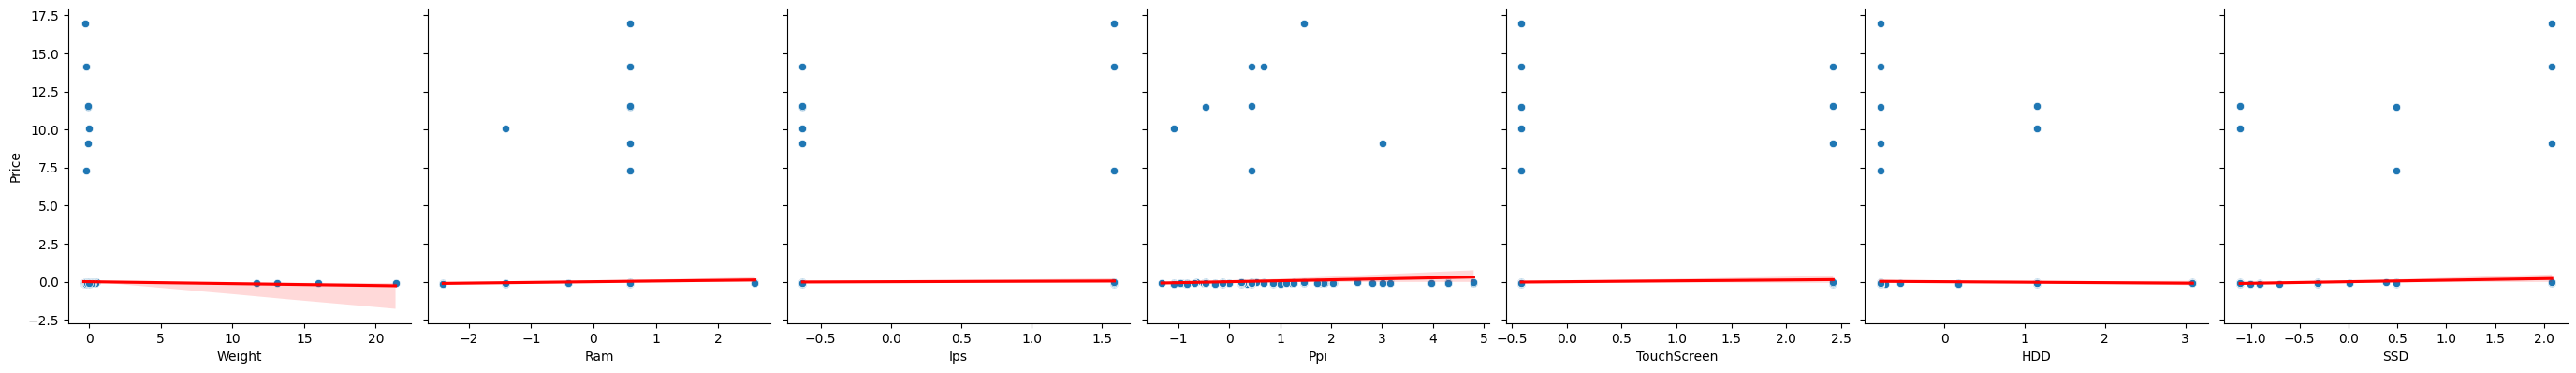

In [ ]:
sns.pairplot(df_laptops, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')
for i, ax in enumerate(plt.gcf().axes):
    if i % len(features) == 0:
        ax.yaxis.label.set_visible(True)
    sns.regplot(data=df_laptops, x=features[i % len(features)], y='Price', scatter=False, line_kws={'color': 'red'}, ax=ax)

plt.show()

<b>$R^2$<b>

In [ ]:
r_squared = pipeline.score(X_test[features], y_test)
print (r_squared)

0.6321414384025179


### 3.3.3 Normalidad de los errores

In [ ]:
errors = (pipeline.predict(X_train) - y_train).values

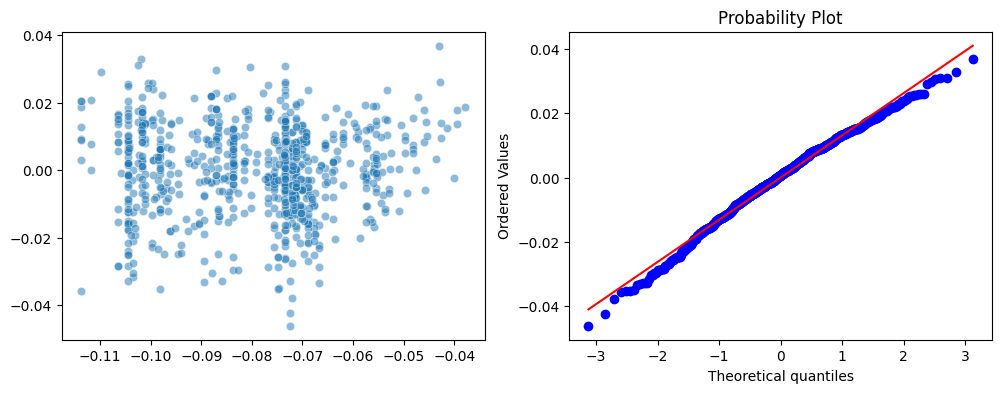

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train), y = errors, alpha = 0.5, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

<b>Eliminar valores atipicos<b>

Para determinar los valores atípicos a remover puede aplicar las reglas  $$outlier > Q3 + 1.5*IQR$$

In [ ]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

-0.019487184574751418

In [ ]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [ ]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [ ]:
pipeline.fit(X_train[features], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [ ]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features]))))

MAE:
Train: 0.010457418758416399
Test: 0.010689006108332667

RMSE:
Train: 0.013140133592420791
Test: 0.013370327854110972


In [ ]:
errors = (pipeline.predict(X_train[features]) - y_train).values

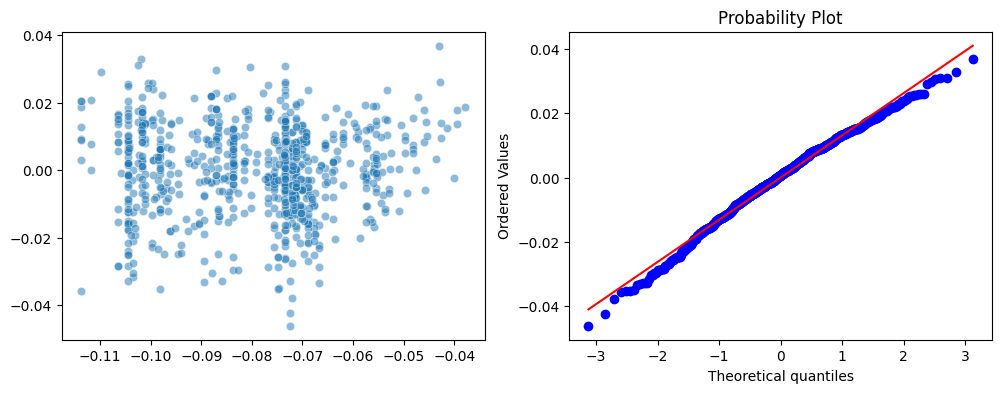

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train[features]), y = errors, alpha = 0.5, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])
plt.show()

### 3.3.4 Varianza constante (Homocedasticidad)


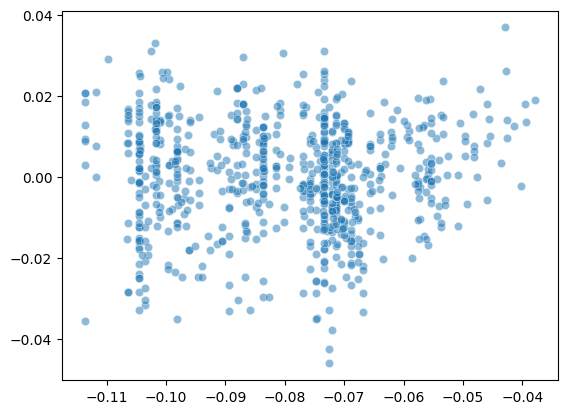

In [ ]:
sns.scatterplot(x = pipeline.predict(X_train[features]), y = errors, alpha = 0.5)
plt.show()

# 7. Exportación del modelo

In [ ]:
filename = 'model.joblib'

In [ ]:
dump(pipeline, filename)

In [ ]:
pipeline_loaded = load(filename)

# 8. Generar predicciones

In [ ]:
df_laptops_new['Price'] = pipeline_loaded.predict(df_laptops[features])

In [ ]:
# Create a histogram plot of selling prices
sns.histplot(df_laptops_new['Price'])

# Set the x limits to range from 0 to 17500
plt.xlim(0, 12000)

# Display the plot
plt.show()

In [544]:
sns.histplot(df_laptops['Price'])
plt.show()

KeyboardInterrupt: 

In [ ]:
output_path = './data/CompuAlpesNew.csv'
df_laptops_new.to_csv(output_path, index=False, sep=',', line_terminator=';\n', quoting=csv.QUOTE_NONE)